# Project X Report

## Team members: 

## Introduction

## Dataset

## Analysis technique

## Results


%%latex
\newpage

# Project X Code


## Imports

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import colorsys
from collections import Counter

## Function to graphically draw neural network

In [65]:
def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)

## Loading wine data

In [66]:
wine_data = pd.read_csv("data/winequality-red.csv")
display(wine_data.head())
display(len(wine_data))

wine_data = wine_data.dropna()
display(len(wine_data))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1599

1599

## EDA

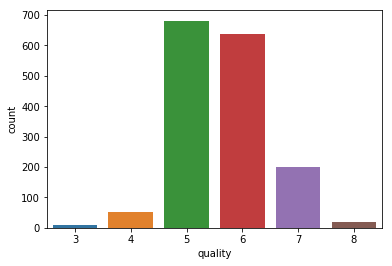

In [67]:
sns.countplot(x='quality', data=wine_data)

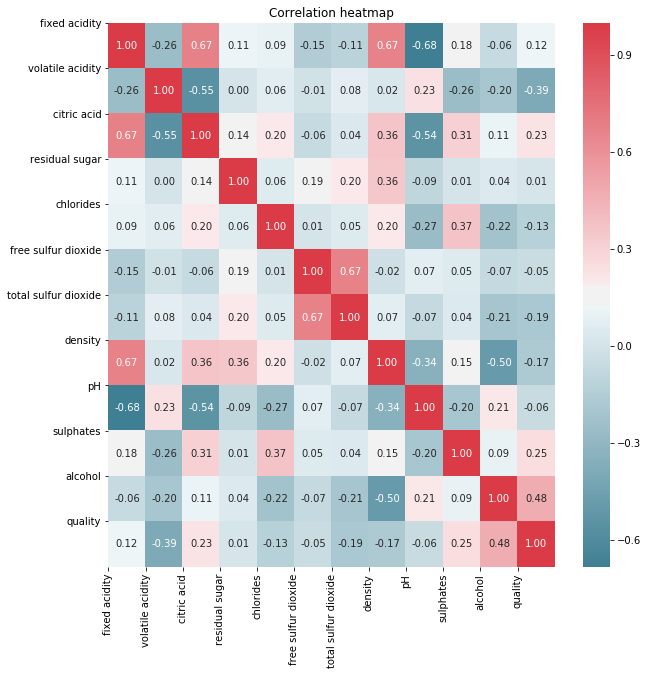

In [68]:
corr_df = wine_data
corr = corr_df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Color Map, red & blue
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Add title
plt.title('Correlation heatmap')
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

## Data Preparation

In [69]:
# Changing the target variable to 0=> Bad, 1=> Good
# So, it is either good quality or bad quality wine
# It will also help in balancing the dataset
wine_data.loc[wine_data.quality <= 5, 'target'] = 0
wine_data.loc[wine_data.quality >= 6, 'target'] = 1

display(wine_data.head())
display(Counter(wine_data['target']))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.0


Counter({0.0: 744, 1.0: 855})

## Train Test split

In [70]:
X = wine_data.drop(['quality','target'],axis=1)
y = wine_data['target']
display(X.head())
display(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: target, dtype: float64

## Scaling the data

In [71]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Neural network 1

In [72]:
mlp1 = MLPClassifier(hidden_layer_sizes=(2, 2),max_iter=500)
mlp1.fit(X_train,y_train)
predictions = mlp1.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[130  48]
 [ 65 157]]
             precision    recall  f1-score   support

        0.0       0.67      0.73      0.70       178
        1.0       0.77      0.71      0.74       222

avg / total       0.72      0.72      0.72       400



In [73]:
print(len(mlp1.coefs_))
print(mlp1.coefs_)

print(len(mlp1.coefs_[0]))

print(len(mlp1.intercepts_[0]))

3
[array([[ 0.08317042, -0.12171715],
       [-0.69081608, -0.41653544],
       [-0.0902027 ,  0.07049579],
       [ 0.28879958,  0.1763687 ],
       [-0.37014993, -1.0780095 ],
       [ 0.44195423,  0.34308847],
       [-0.64722081,  0.18980807],
       [-0.30138618, -0.16304698],
       [ 0.03821272,  0.42664715],
       [ 0.29133031, -1.1318314 ],
       [ 0.88087994, -0.13948522]]), array([[-1.1826291 ,  1.0732907 ],
       [ 0.34059206, -1.32708423]]), array([[-0.90016943],
       [ 0.56483436]])]
11
2


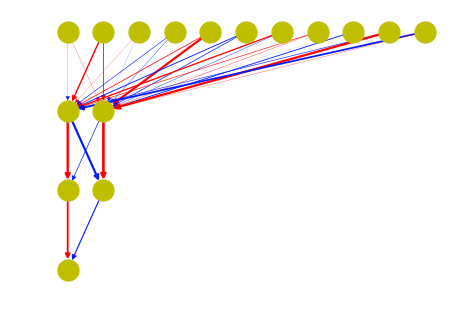

In [74]:
show_ann(mlp1)

## Neural Network 2

In [75]:
mlp2 = MLPClassifier(hidden_layer_sizes=(15, 15, 15),max_iter=10000)
mlp2.fit(X_train,y_train)
predictions = mlp2.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[134  44]
 [ 45 177]]
             precision    recall  f1-score   support

        0.0       0.75      0.75      0.75       178
        1.0       0.80      0.80      0.80       222

avg / total       0.78      0.78      0.78       400



In [ ]:
show_ann(mlp2)

## Neural Network 3

In [ ]:
mlp3 = MLPClassifier(hidden_layer_sizes=(30, 30, 15),max_iter=10000)
mlp3.fit(X_train,y_train)
predictions = mlp3.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

In [ ]:
show_ann(mlp2)

In [ ]:
mlp4 = MLPClassifier(activation='logistic', solver='adam', learning_rate='adaptive',hidden_layer_sizes=(30, 30, 15),max_iter=10000)
mlp4.fit(X_train,y_train)
predictions = mlp4.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))